# Marketing campaign metrics and analysis

- How did a marketing campaign perform?
- Which channel outperformed/underperformed?
- Why factors impact the channel performance?

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data import

In [2]:
data = pd.read_csv('marketing_campaign.csv', index_col = 0)
data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,1/1/2018,House Ads,personalization,True,English,English,0-18 years,1/1/2018,NaN,House Ads,True
1,a100000030,1/1/2018,House Ads,personalization,True,English,English,19-24 years,1/1/2018,NaN,House Ads,True
2,a100000031,1/1/2018,House Ads,personalization,True,English,English,24-30 years,1/1/2018,NaN,House Ads,True
3,a100000032,1/1/2018,House Ads,personalization,True,English,English,30-36 years,1/1/2018,NaN,House Ads,True
4,a100000033,1/1/2018,House Ads,personalization,True,English,English,36-45 years,1/1/2018,NaN,House Ads,True


In [3]:
data.shape

(10037, 12)

## Data preprocessing

### Duplicate

In [4]:
data.duplicated().sum()

37

In [5]:
data.drop_duplicates(subset=None, keep='first', inplace=True)

In [6]:
data.duplicated(['user_id']).sum()

2691

In [7]:
data[data.duplicated(['user_id'],keep=False)].head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
21,a100000050,1/2/2018,House Ads,personalization,True,English,English,24-30 years,1/2/2018,NaN,House Ads,True
22,a100000050,1/1/2018,House Ads,personalization,False,English,English,24-30 years,1/2/2018,NaN,House Ads,True
23,a100000051,1/2/2018,House Ads,personalization,True,English,English,30-36 years,1/2/2018,NaN,House Ads,True
24,a100000051,1/1/2018,Push,personalization,False,English,English,30-36 years,1/2/2018,NaN,House Ads,True
25,a100000052,1/2/2018,House Ads,personalization,True,English,English,36-45 years,1/2/2018,NaN,House Ads,True


### Data types

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10000 non-null  object
 1   date_served          9984 non-null   object
 2   marketing_channel    9985 non-null   object
 3   variant              10000 non-null  object
 4   converted            10000 non-null  bool  
 5   language_displayed   10000 non-null  object
 6   language_preferred   10000 non-null  object
 7   age_group            10000 non-null  object
 8   date_subscribed      1845 non-null   object
 9   date_canceled        575 non-null    object
 10  subscribing_channel  1845 non-null   object
 11  is_retained          10000 non-null  bool  
dtypes: bool(2), object(10)
memory usage: 878.9+ KB


In [9]:
for col in ['date_served', 'date_subscribed', 'date_canceled']:
    data[col] = pd.to_datetime(data[col], format='%m/%d/%Y', errors='ignore')

data.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True


### Missing values

In [10]:
res = dict()

for col in data.columns:
    res[col] = round((1-data[col].count()/len(data))*100, 2)

pd.DataFrame(res.items(), columns=['Variable', 'Missing(%)'])

,Variable,Missing(%)
0,user_id,0.00
1,date_served,0.16
2,marketing_channel,0.15
3,variant,0.00
4,converted,0.00
5,language_displayed,0.00
6,language_preferred,0.00
7,age_group,0.00
8,date_subscribed,81.55
9,date_canceled,94.25


Observation: large percentage of missing values for date_subscribed, date_canceled, subscribing_channel.

### Success metrics

In [11]:
data['converted'].value_counts()

False    8911
True     1089
Name: converted, dtype: int64

In [12]:
data['is_retained'].value_counts()

True     9425
False     575
Name: is_retained, dtype: int64

### Feature engineering

In [13]:
# DoW: day of week, represents the day of the week as an integer
data['DoW'] = data['date_subscribed'].dt.dayofweek

In [14]:
# language_match: ad shown to the user in their perferred lanauage or not
data['language_match'] = \
    np.where(data['language_preferred'] == data['language_displayed'], 'Yes', 'No')

### Feature encoding

In [15]:
# Mapping for channels
channel_dict = {"House Ads": 1, "Instagram": 2, 
                "Facebook": 3, "Email": 4, "Push": 5}

# Map the channel to a channel code
data['channel_code'] = data['subscribing_channel'].map(channel_dict)

## Data analysis

### Daily marketing reach

How many users see the marketing materials

In [16]:
# Group by date_served and count number of unique user_id's
daily_users = data.groupby(['date_served'])['user_id'].nunique()
daily_users_df = daily_users.reset_index()
daily_users_df.rename(columns = {'user_id':'user_number'}, inplace = True)

daily_users_df.head()

,date_served,user_number
0,2018-01-01,362
1,2018-01-02,374
2,2018-01-03,348
3,2018-01-04,323
4,2018-01-05,319


In [17]:
daily_users_df['date_served'][0]

Timestamp('2018-01-01 00:00:00')

In [18]:
daily_users_df['date_served'].iloc[-1]

Timestamp('2018-01-31 00:00:00')

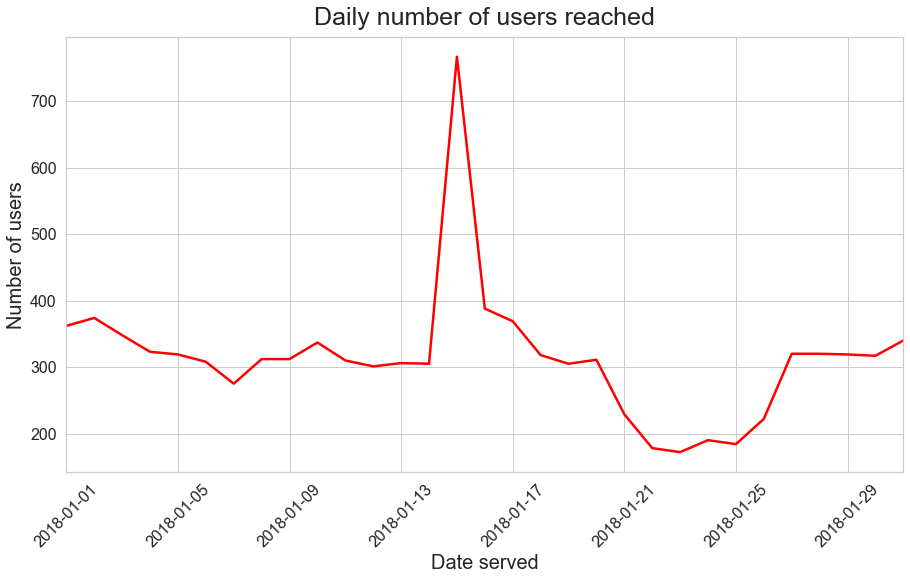

In [19]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")

fig = sns.lineplot(x = "date_served", y = "user_number",
                   data = daily_users_df, color='red', linewidth=2.5)
fig.set_title("Daily number of users reached", fontsize = 25, pad=12)
fig.set_xlabel("Date served", fontsize = 20)
fig.set_ylabel("Number of users", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(daily_users_df['date_served'][0], 
         daily_users_df['date_served'].iloc[-1])

plt.show()

We see a huge spike in the middle of the month. A possible explanation is the rollout of a big marketing campaign, which reached many new users or inactive users.

### Daily conversion rate

Conversion rate is a key metric.

Monitoring metric over time can reveal the potential time pattern of gaining new subscribers. For example, holiday seasons and/or weekends may have positive impact on conversion rate.

In [20]:
# Group by date_served and count unique converted users
subscriber_df = data[data['converted'] == True].groupby(['date_served'])\
                         ['user_id'].nunique().reset_index()
subscriber_df.rename(columns = {'user_id': 'Subscriptions'}, inplace=True)

subscriber_df.head()

,date_served,Subscriptions
0,2018-01-01,36
1,2018-01-02,37
2,2018-01-03,36
3,2018-01-04,35
4,2018-01-05,40


In [21]:
conversion_df = pd.merge(daily_users_df, subscriber_df,
                         on='date_served', how='left')

conversion_df.head()

,date_served,user_number,Subscriptions
0,2018-01-01,362,36
1,2018-01-02,374,37
2,2018-01-03,348,36
3,2018-01-04,323,35
4,2018-01-05,319,40


In [22]:
conversion_df['conv_rate(%)'] =\
    round(conversion_df.Subscriptions/conversion_df.user_number*100,0)

conversion_df['conv_rate(%)'].fillna(0, inplace=True)

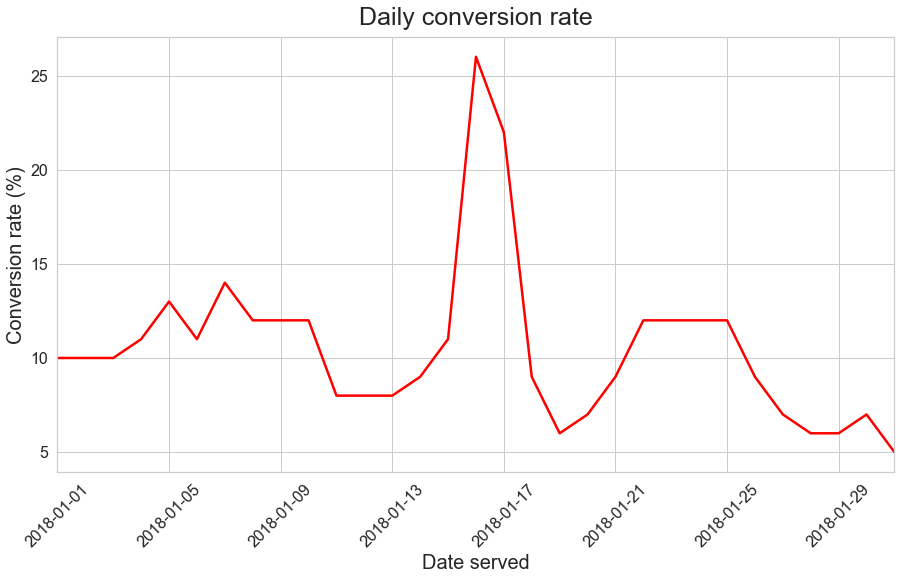

In [23]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")

fig = sns.lineplot(x = "date_served", y = "conv_rate(%)",
                   data = conversion_df, color='red', linewidth=2.5)
fig.set_title("Daily conversion rate", fontsize = 25, pad=12)
fig.set_xlabel("Date served", fontsize = 20)
fig.set_ylabel("Conversion rate (%)", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(daily_users_df['date_served'][0], 
         daily_users_df['date_served'].iloc[-1])

plt.show()

In [24]:
# Total conversion rate
total_conv_r = data[data["converted"] == True]['user_id'].nunique()/\
    data['user_id'].nunique()

print("Total conversion rate is {}%.".format(round(total_conv_r*100, 1)))

Total conversion rate is 14.1%.


The big marketing campaign in the middle of the month not only increased the number of users reached but also the conversion rate. However, after the conversion rate appears to be going down for the second half of the month.

#### Daily conversion rate by age group

In [25]:
data[data['converted'] == True].\
    groupby(['date_served','age_group'])['user_id'].nunique()

date_served  age_group  
2018-01-01   0-18 years      9
             19-24 years    12
             24-30 years     6
             30-36 years     2
             36-45 years     2
                            ..
2018-01-31   19-24 years     6
             24-30 years     3
             36-45 years     2
             45-55 years     1
             55+ years       1
Name: user_id, Length: 195, dtype: int64

In [26]:
data.groupby(['date_served','age_group'])['user_id'].nunique()

date_served  age_group  
2018-01-01   0-18 years     58
             19-24 years    61
             24-30 years    57
             30-36 years    49
             36-45 years    47
                            ..
2018-01-31   24-30 years    52
             30-36 years    44
             36-45 years    57
             45-55 years    43
             55+ years      38
Name: user_id, Length: 217, dtype: int64

In [27]:
column_conv = data[data['converted'] == True].\
    groupby(['date_served','age_group'])['user_id'].nunique()
column_total = data.groupby(['date_served','age_group'])['user_id'].nunique()

column_conv/column_total

date_served  age_group  
2018-01-01   0-18 years     0.155172
             19-24 years    0.196721
             24-30 years    0.105263
             30-36 years    0.040816
             36-45 years    0.042553
                              ...   
2018-01-31   24-30 years    0.057692
             30-36 years         NaN
             36-45 years    0.035088
             45-55 years    0.023256
             55+ years      0.026316
Name: user_id, Length: 217, dtype: float64

In [28]:
conversion_rate_t = column_conv/column_total
conversion_rate = conversion_rate_t.fillna(0)
conversion_rate

date_served  age_group  
2018-01-01   0-18 years     0.155172
             19-24 years    0.196721
             24-30 years    0.105263
             30-36 years    0.040816
             36-45 years    0.042553
                              ...   
2018-01-31   24-30 years    0.057692
             30-36 years    0.000000
             36-45 years    0.035088
             45-55 years    0.023256
             55+ years      0.026316
Name: user_id, Length: 217, dtype: float64

In [29]:
## Building a conversion function
def conversion_rate(dataframe, column_names):
    # Total number of converted users
    column_conv = dataframe[dataframe['converted'] == True]\
                       .groupby(column_names)['user_id'].nunique()

    # Total number of users
    column_total = dataframe.groupby(column_names)['user_id'].nunique()   
    
    # Conversion rate 
    conversion_rate_t = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate_t.fillna(0)
    return conversion_rate

In [30]:
# Calculate conversion rate by date served and age group
conv_r_age = conversion_rate(data, ['date_served', 'age_group'])

In [31]:
conv_r_age.unstack(level = 1) # or -1, i.e. last level

age_group,0-18 years,19-24 years,24-30 years,30-36 years,36-45 years,45-55 years,55+ years
date_served,,,,,,,
2018-01-01,0.155172,0.196721,0.105263,0.040816,0.042553,0.022222,0.086957
2018-01-02,0.180328,0.164384,0.114754,0.040000,0.043478,0.043478,0.024390
2018-01-03,0.102041,0.208955,0.150943,0.042553,0.060000,0.047619,0.043478
2018-01-04,0.117647,0.200000,0.183673,0.045455,0.043478,0.061224,0.073171
2018-01-05,0.142857,0.250000,0.136364,0.090909,0.068182,0.046512,0.088889
2018-01-06,0.120000,0.188679,0.145833,0.078947,0.073171,0.068182,0.078947
2018-01-07,0.128205,0.220000,0.153846,0.100000,0.111111,0.128205,0.117647
2018-01-08,0.142857,0.196078,0.140000,0.069767,0.069767,0.051282,0.102564
2018-01-09,0.148936,0.200000,0.152174,0.090909,0.093023,0.068182,0.102564


In [32]:
conv_r_age_df = pd.DataFrame(conv_r_age.unstack(level = 1))

In [33]:
conv_r_age_df = conv_r_age_df.reset_index()

In [34]:
conv_r_age_df.head()

age_group,date_served,0-18 years,19-24 years,24-30 years,30-36 years,36-45 years,45-55 years,55+ years
0,2018-01-01,0.155172,0.196721,0.105263,0.040816,0.042553,0.022222,0.086957
1,2018-01-02,0.180328,0.164384,0.114754,0.040000,0.043478,0.043478,0.024390
2,2018-01-03,0.102041,0.208955,0.150943,0.042553,0.060000,0.047619,0.043478
3,2018-01-04,0.117647,0.200000,0.183673,0.045455,0.043478,0.061224,0.073171
4,2018-01-05,0.142857,0.250000,0.136364,0.090909,0.068182,0.046512,0.088889


In [35]:
value_vars = conv_r_age_df.columns[1:].to_list()

conv_r_age_plt = conv_r_age_df.melt(id_vars = ["date_served"], 
                              value_vars = value_vars)

conv_r_age_plt.head()

,date_served,age_group,value
0,2018-01-01,0-18 years,0.155172
1,2018-01-02,0-18 years,0.180328
2,2018-01-03,0-18 years,0.102041
3,2018-01-04,0-18 years,0.117647
4,2018-01-05,0-18 years,0.142857


In [36]:
conv_r_age_plt['value'] = round(conv_r_age_plt['value']*100,0)

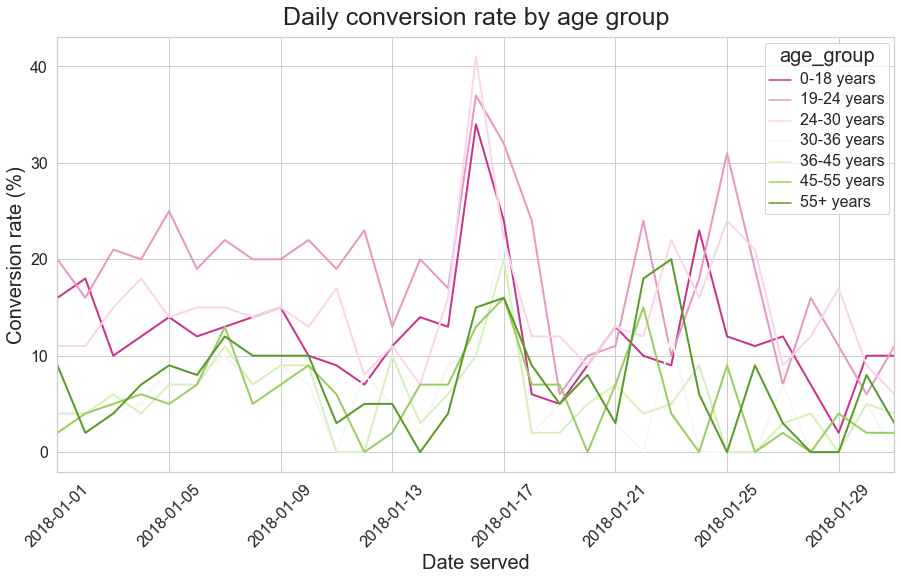

In [37]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")
sequential_colors = sns.color_palette("PiYG", len(value_vars))

fig = sns.lineplot(x = "date_served", y = "value", hue = 'age_group',
                   dashes =[(1, 1), (5, 10)], palette=sequential_colors,
                   linewidth = 2,
                   data = conv_r_age_plt)
fig.set_title("Daily conversion rate by age group", fontsize = 25, pad=12)
fig.set_xlabel("Date served", fontsize = 20)
fig.set_ylabel("Conversion rate (%)", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(daily_users_df['date_served'][0], 
         daily_users_df['date_served'].iloc[-1])

plt.setp(fig.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(fig.get_legend().get_title(), fontsize='20') # for legend title


plt.show()

Age group of 19-24 years exhibited relatively high conversion rate. 44-55 years and 55+ years groups showed relatively low conversion rates.

### Retention rate

In [38]:
data.iloc[5:15,:]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,language_match,channel_code
5,a100000034,2018-01-01,House Ads,personalization,True,German,German,45-55 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
6,a100000035,2018-01-01,House Ads,personalization,True,English,English,55+ years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
7,a100000036,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
8,a100000037,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
9,a100000038,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
10,a100000039,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True,0.0,Yes,1.0
11,a100000040,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-01-18,House Ads,False,0.0,Yes,1.0
12,a100000041,2018-01-01,House Ads,personalization,True,Arabic,Arabic,24-30 years,2018-01-01,2018-02-22,House Ads,False,0.0,Yes,1.0
13,a100000042,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,2018-03-09,House Ads,False,0.0,Yes,1.0
14,a100000043,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,2018-02-18,House Ads,False,0.0,Yes,1.0


This business makes profit from subscriptions, similar to SaaS. Therefore, when we eveluate customer retention/churn, we want to know how many customers keep an active paying subscription.

Formula to calculate Customer Retention Rate (CRR) is [(E-N)/S] x 100
1. The number of total customers at the end of the time period (E)
2. The number of new customers added within the time period (N)
3. The number of existing customers at the start of the time period (S)

In [39]:
data['date_canceled'].value_counts()

2018-04-01    14
2018-04-02    14
2018-01-11    13
2018-03-04    12
2018-03-03    11
              ..
2018-01-15     1
2018-01-05     1
2018-02-15     1
2018-03-29     1
2018-03-20     1
Name: date_canceled, Length: 115, dtype: int64

If a user canceled the subscription after 2018-01-31, is_retain is marked False. However, this user should be considered retained if we calculate daily retention rate between 2018-01-01 and 2018-01-31 or monthly retention rate between 2018-01-01 and 2018-01-31. We need to treat "is_retained" carefully.

#### Daily customer retention rate

In [40]:
# Daily CRR
# E: date_subscribed <= today & (date_canceled > today | is_retained == True)
# N: date_subscribed == today
# S: data_subscribed < today & (date_canceled > today | is_retained == True)

In [41]:
dates = data['date_served'].unique()
dates

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-20T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28

In [42]:
dates = dates[0:-1]
daily_crr = []
new = []
start = []
end = []

for i in dates:
    
    N = data[data['date_subscribed'] == i]['user_id'].nunique()
    E = data[(data['date_subscribed'] <= i)\
                  & ((data['date_canceled'] > i)\
                 | (data['is_retained'] == True))]\
                ['user_id'].nunique()
    S = data[(data['date_subscribed'] < i)\
                  & ((data['date_canceled'] > i)\
                 | (data['is_retained'] == True))]\
                ['user_id'].nunique()
    
#     N = np.array(data['date_subscribed'] == i).sum()
#     E = np.array((data['date_subscribed'] <= i)\
#                  & ((data['date_canceled'] > i)\
#                 | (data['is_retained'] == True))).sum()
    
#     S = np.array((data['date_subscribed'] < i)\
#                  & ((data['date_canceled'] > i)\
#                 | (data['is_retained'] == True))).sum()
    
    
    new.append(N)
    start.append(S)
    end.append(E)
    
    
    if S > 0:
        CRR = (E-N)/S
    else:
        CRR = 0
    daily_crr.append(CRR)

print(daily_crr)

print(new)
print(start)
print(end)

[0, 1.0, 1.0, 1.0, 0.993103448275862, 0.9944444444444445, 0.9953488372093023, 0.9960159362549801, 0.9964664310954063, 0.996875, 0.9943661971830986, 0.9947089947089947, 0.9949748743718593, 0.9976190476190476, 0.9954954954954955, 0.9941176470588236, 0.9967213114754099, 0.9971139971139971, 0.9986111111111111, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[36, 37, 37, 36, 40, 37, 38, 36, 40, 41, 26, 23, 26, 26, 70, 104, 86, 30, 19, 21, 21, 22, 21, 23, 23, 20, 21, 21, 20, 21, 18]
[0, 36, 73, 110, 145, 180, 215, 251, 283, 320, 355, 378, 398, 420, 444, 510, 610, 693, 720, 737, 754, 772, 789, 807, 824, 845, 862, 879, 897, 913, 933]
[36, 73, 110, 146, 184, 216, 252, 286, 322, 360, 379, 399, 422, 445, 512, 611, 694, 721, 738, 758, 775, 794, 810, 830, 847, 865, 883, 900, 917, 934, 951]


In [43]:
daily_crr_df = pd.DataFrame({'date_served': dates, 'daily_crr': daily_crr})
daily_crr_df['daily_crr(%)'] = round(daily_crr_df['daily_crr']*100,1)
daily_crr_df.drop(columns='daily_crr', inplace=True)
daily_crr_df

,date_served,daily_crr(%)
0,2018-01-01,0.0
1,2018-01-02,100.0
2,2018-01-03,100.0
3,2018-01-04,100.0
4,2018-01-05,99.3
5,2018-01-06,99.4
6,2018-01-07,99.5
7,2018-01-08,99.6
8,2018-01-09,99.6
9,2018-01-10,99.7


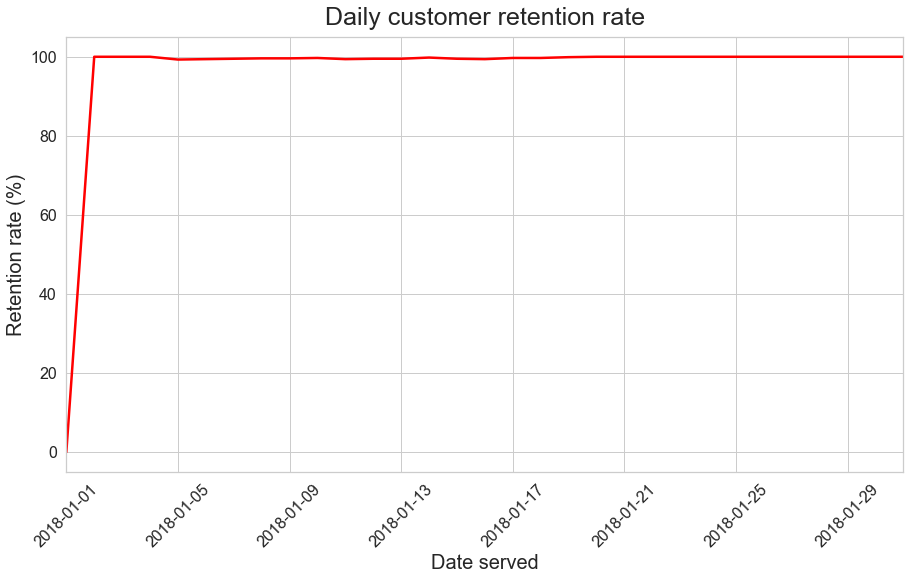

In [44]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")

fig = sns.lineplot(x = "date_served", y = "daily_crr(%)",
                   data = daily_crr_df, color='red', linewidth=2.5)
fig.set_title("Daily customer retention rate", fontsize = 25, pad=12)
fig.set_xlabel("Date served", fontsize = 20)
fig.set_ylabel("Retention rate (%)", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(daily_users_df['date_served'][0], 
         daily_users_df['date_served'].iloc[-1])

plt.show()

In [45]:
daily_user_df = pd.DataFrame({'date_served': dates, 'user_end': end})
daily_user_df

,date_served,user_end
0,2018-01-01,36
1,2018-01-02,73
2,2018-01-03,110
3,2018-01-04,146
4,2018-01-05,184
5,2018-01-06,216
6,2018-01-07,252
7,2018-01-08,286
8,2018-01-09,322
9,2018-01-10,360


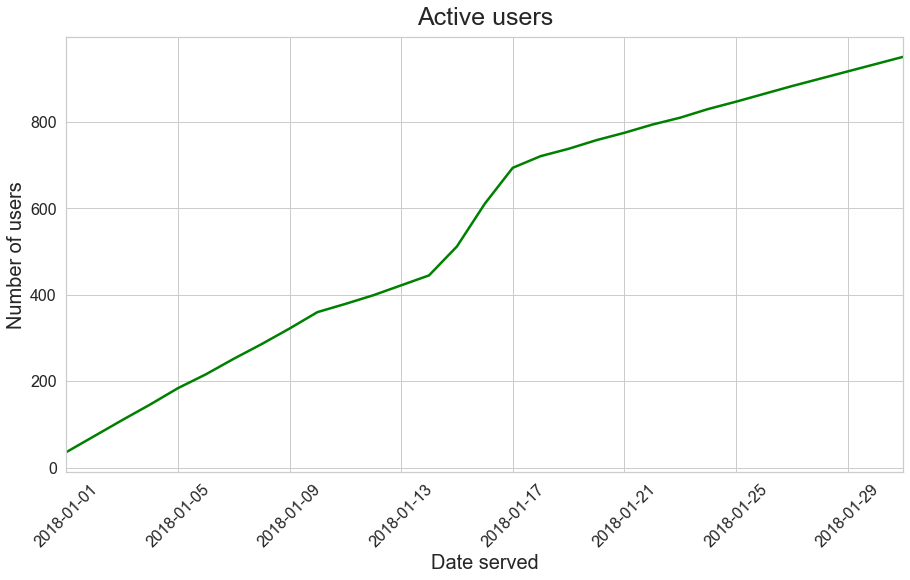

In [46]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")

fig = sns.lineplot(x = "date_served", y = "user_end",
                   data = daily_user_df, color='green', linewidth=2.5)
fig.set_title("Active users", fontsize = 25, pad=12)
fig.set_xlabel("Date served", fontsize = 20)
fig.set_ylabel("Number of users", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(daily_users_df['date_served'][0], 
         daily_users_df['date_served'].iloc[-1])

plt.show()

#### Monthly customer retention rate

In [47]:
# Monthly CRR
# Cannot use is_retained; e.g., data_canceled=2018-03-09, is_retained=False
# E: date_subscribed <= 2018-01-31 & (date_canceled >= 2018-01-31 | is_retained == True)
# N: date_subscribed >= 2018-01-01 & date_subscribed <= 2018-01-31
# S: data_subscribed < 2018-01-01 (date_canceled >= 2018-01-01 | is_retained == True)

In [48]:
start_day = dates[0]
end_day = dates[-1]

In [49]:
N = data[(data['date_subscribed'] >= start_day)\
         & (data['date_subscribed'] <= end_day)]\
            ['user_id'].nunique()
E = data[(data['date_subscribed'] <= end_day)\
              & ((data['date_canceled'] > end_day)\
             | (data['is_retained'] == True))]\
            ['user_id'].nunique()
S = data[(data['date_subscribed'] < start_day)\
              & ((data['date_canceled'] >= start_day)\
             | (data['is_retained'] == True))]\
            ['user_id'].nunique()

if S>0:
    CRR = (E-N)/S
    print("Monthy customer retention rate from 2018-01-01 to 2018-01-31 is {}%.".\
          format(round(CRR*100,1)))
else:
    print("No existing customers before the start_day.")

No existing customers before the start_day.


In [50]:
# Calculate the latter half of the month

start_day = dates[14]
end_day = dates[-1]

N = data[(data['date_subscribed'] >= start_day)\
         & (data['date_subscribed'] <= end_day)]\
            ['user_id'].nunique()
E = data[(data['date_subscribed'] <= end_day)\
              & ((data['date_canceled'] > end_day)\
             | (data['is_retained'] == True))]\
            ['user_id'].nunique()
S = data[(data['date_subscribed'] < start_day)\
              & ((data['date_canceled'] >= start_day)\
             | (data['is_retained'] == True))]\
            ['user_id'].nunique()

if S>0:
    CRR = (E-N)/S
    print("Monthy customer retention rate from 2018-01-15 to 2018-01-31 is {}%.".\
          format(round(CRR*100,1)))
else:
    print("No existing customers before the start_day.")

Monthy customer retention rate from 2018-01-15 to 2018-01-31 is 87.6%.


#### Customer retention from a cohort analysis perspective

Here we can treat users who started subscription on the same day as one cohort.

Ref: https://www.profitwell.com/customer-churn/analysis

Separating your customers into cohorts based on when they sign up and their product usage behavior can be hugely helpful in analyzing, anticipating, and preventing churn. Note similarities in customer behavior, like:
- Which customers are more likely to disengage after a given period of time
- Which features of your product are the most highly or underutilized
- Which customers are at a higher risk of delinquent churn
- Which portion of customers are using your support services

In [51]:
# Number of unique users that started subscription on each day
total = data.groupby(["date_subscribed"])\
                    ['user_id'].nunique()

# Number of users who remained subscribed until now (past 2018-01-31)
retained = data[data['is_retained'] == True]\
            .groupby(['date_subscribed'])['user_id'].nunique()

# Calculate the retention rate for cohorts
retention_rate = round(retained/total*100, 1)
retention_rate

date_subscribed
2018-01-01    77.8
2018-01-02    70.3
2018-01-03    73.0
2018-01-04    50.0
2018-01-05    57.5
2018-01-06    75.7
2018-01-07    52.6
2018-01-08    63.9
2018-01-09    67.5
2018-01-10    68.3
2018-01-11    61.5
2018-01-12    39.1
2018-01-13    50.0
2018-01-14    61.5
2018-01-15    71.4
2018-01-16    70.2
2018-01-17    61.6
2018-01-18    73.3
2018-01-19    68.4
2018-01-20    81.0
2018-01-21    76.2
2018-01-22    77.3
2018-01-23    71.4
2018-01-24    65.2
2018-01-25    56.5
2018-01-26    80.0
2018-01-27    57.1
2018-01-28    66.7
2018-01-29    75.0
2018-01-30    71.4
2018-01-31    66.7
Name: user_id, dtype: float64

In [52]:
retention_rate_plt = retention_rate.reset_index()
retention_rate_plt.rename(columns={'user_id':'retention_rate(%)'}, inplace=True)

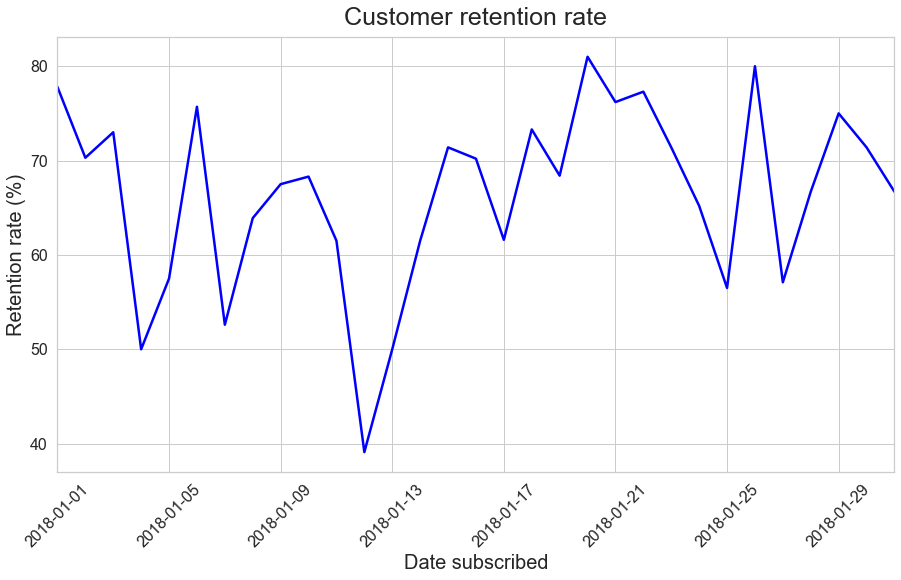

In [53]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")

fig = sns.lineplot(x = "date_subscribed", y = "retention_rate(%)",
                   data = retention_rate_plt, color='blue', linewidth=2.5)
fig.set_title("Customer retention rate", fontsize = 25, pad=12)
fig.set_xlabel("Date subscribed", fontsize = 20)
fig.set_ylabel("Retention rate (%)", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(retention_rate_plt['date_subscribed'][0], 
         retention_rate_plt['date_subscribed'].iloc[-1])

plt.show()

Now we break down the retention rate by channel.

In [54]:
# Building a retention function
def retention_rate(dataframe, column_names):
    # Total number of retained users
    column_retain = dataframe[dataframe['is_retained'] == True]\
                       .groupby(column_names)['user_id'].nunique()

    # Total number of converted users
    column_convert = dataframe[dataframe['converted'] == True]\
                       .groupby(column_names)['user_id'].nunique() 
    
    # Retention rate 
    retention_rate_c = column_retain/column_convert
    
    # Fill missing values with 0
    retention_rate = retention_rate_c.fillna(0)
    return retention_rate

In [55]:
retention_r_channel = retention_rate(data, ['date_subscribed', 'subscribing_channel'])

retention_r_channel = pd.DataFrame(retention_r_channel.unstack(level = 1)).reset_index()

value_vars = retention_r_channel.columns[1:].to_list()

retention_r_channel_plt = retention_r_channel.melt(id_vars = ["date_subscribed"], 
                              value_vars = value_vars)

retention_r_channel_plt['value'] = round(retention_r_channel_plt['value']*100,0)

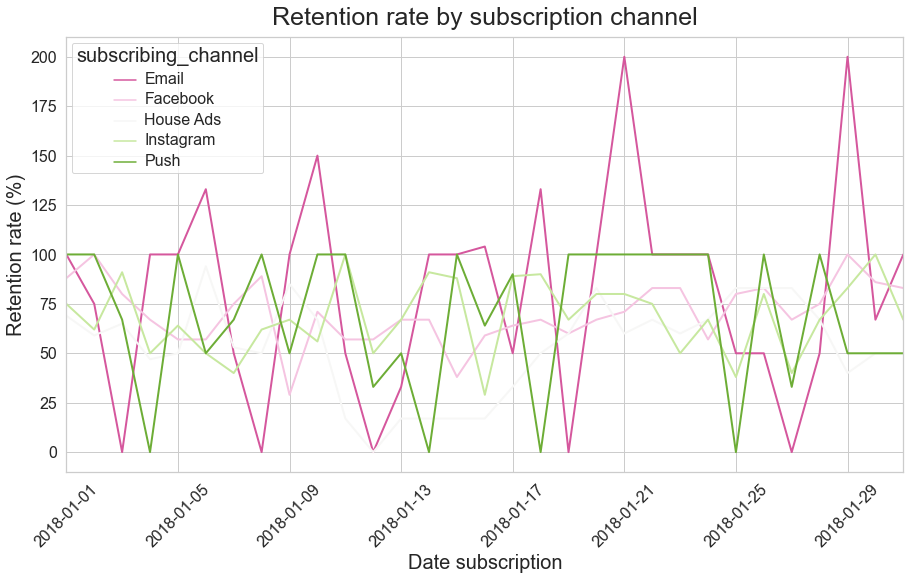

In [56]:
sns.set(rc = {'figure.figsize': (15, 8)})
sns.set_style("whitegrid")
sequential_colors = sns.color_palette("PiYG", len(value_vars))

fig = sns.lineplot(x = "date_subscribed", y = "value", hue = 'subscribing_channel',
                   dashes =[(1, 1), (5, 10)], palette=sequential_colors,
                   linewidth = 2,
                   data = retention_r_channel_plt)
fig.set_title("Retention rate by subscription channel", fontsize = 25, pad=12)
fig.set_xlabel("Date subscription", fontsize = 20)
fig.set_ylabel("Retention rate (%)", fontsize = 20)

fig.tick_params(labelsize= 16)
plt.xticks(rotation = 45)
plt.xlim(retention_rate_plt['date_subscribed'][0], 
         retention_rate_plt['date_subscribed'].iloc[-1])

plt.setp(fig.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(fig.get_legend().get_title(), fontsize='20') # for legend title


plt.show()

### Cohort analysis

In [57]:
 data.groupby('user_id')['date_subscribed'].count().value_counts()

0     6289
2      466
1      456
3       55
4       15
10      14
5        8
8        5
12       1
Name: date_subscribed, dtype: int64

It is a bit odd that some user id's have more than one subscription date.

In [58]:
 data.groupby('user_id')['date_subscribed'].nunique().value_counts()

0    6289
1    1000
2      20
Name: date_subscribed, dtype: int64

Most user id's have one unique subscription date. A little less than 2% of user id's that have made subscriptions have two subscription dates.

Cohort analysis is about acquired users. It should be ok to remove user id's that did not subscribe.

In [59]:
data2 = data.dropna(axis=0, subset=['date_subscribed'], inplace=False)
data2.shape

(1845, 15)

In [60]:
data2[data2.duplicated(subset=['user_id'], keep=False)]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,language_match,channel_code
21,a100000050,2018-01-02,House Ads,personalization,True,English,English,24-30 years,2018-01-02,NaT,House Ads,True,1.0,Yes,1.0
22,a100000050,2018-01-01,House Ads,personalization,False,English,English,24-30 years,2018-01-02,NaT,House Ads,True,1.0,Yes,1.0
23,a100000051,2018-01-02,House Ads,personalization,True,English,English,30-36 years,2018-01-02,NaT,House Ads,True,1.0,Yes,1.0
24,a100000051,2018-01-01,Push,personalization,False,English,English,30-36 years,2018-01-02,NaT,House Ads,True,1.0,Yes,1.0
25,a100000052,2018-01-02,House Ads,personalization,True,English,English,36-45 years,2018-01-02,NaT,House Ads,True,1.0,Yes,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,a100001379,2018-01-05,Push,control,False,English,English,36-45 years,2018-01-14,2018-03-15,Push,False,6.0,Yes,5.0
1811,a100001380,2018-01-15,Facebook,personalization,True,English,English,24-30 years,2018-01-15,2018-01-22,Facebook,False,0.0,Yes,3.0
1812,a100001380,2018-01-05,Facebook,control,False,English,English,45-55 years,2018-01-15,2018-01-22,Facebook,False,0.0,Yes,3.0
1813,a100001381,2018-01-16,Instagram,personalization,True,English,English,19-24 years,2018-01-16,2018-02-02,Instagram,False,1.0,Yes,2.0


The table above confirms that the data is a snapshot after the campaign was finished on 2018-01-31. User churn was monitored until 2018-05-09 or later.

In [61]:
 data2.groupby('user_id')['date_subscribed'].nunique().reset_index()

,user_id,date_subscribed
0,a100000029,1
1,a100000030,1
2,a100000031,1
3,a100000032,1
4,a100000033,1
...,...,...
1015,a100007290,1
1016,a100007291,1
1017,a100007292,1
1018,a100007293,1


In [62]:
temp_df = (data2.groupby('user_id')['date_subscribed'].nunique() > 1).reset_index()
    
use_id_two_subscription = temp_df[temp_df['date_subscribed']]['user_id'].to_list()

use_id_two_subscription

['a100000875',
 'a100000876',
 'a100000877',
 'a100000878',
 'a100000879',
 'a100000880',
 'a100000881',
 'a100000882',
 'a100000883',
 'a100000884',
 'a100000885',
 'a100000886',
 'a100000887',
 'a100000888',
 'a100000889',
 'a100000890',
 'a100000891',
 'a100000892',
 'a100000893',
 'a100000894']

In [63]:
data2.loc[data2['user_id'].isin(use_id_two_subscription)]

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,language_match,channel_code
808,a100000875,2018-01-07,Instagram,personalization,True,English,English,19-24 years,2018-01-07,2018-03-28,Instagram,False,6.0,Yes,2.0
809,a100000875,2018-01-07,Instagram,personalization,True,English,English,19-24 years,2018-01-11,NaT,Instagram,True,3.0,Yes,2.0
810,a100000875,2018-01-11,Instagram,control,True,English,English,45-55 years,2018-01-07,2018-03-28,Instagram,False,6.0,Yes,2.0
811,a100000875,2018-01-11,Instagram,control,True,English,English,45-55 years,2018-01-11,NaT,Instagram,True,3.0,Yes,2.0
812,a100000875,2018-01-02,House Ads,personalization,False,English,English,19-24 years,2018-01-07,2018-03-28,Instagram,False,6.0,Yes,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,a100000894,2018-01-12,Instagram,control,True,English,English,30-36 years,2018-01-12,NaT,Instagram,True,4.0,Yes,2.0
1000,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-08,2018-04-02,Instagram,False,0.0,Yes,2.0
1001,a100000894,2018-01-03,House Ads,control,False,English,English,30-36 years,2018-01-12,NaT,Instagram,True,4.0,Yes,2.0
1002,a100000894,2018-01-03,House Ads,control,False,English,English,24-30 years,2018-01-08,2018-04-02,Instagram,False,0.0,Yes,2.0


The table above suggests some potential data quality issues associated with certain user id's. For example, user id a100000875 is in two age groups, 19-24 years and 45-55 years. In addition, this user id has two subscription date, 2018-01-07 and 2018-01-11. The first subscription was canceled on 2018-03-28, while the second subscription was active as of the date of the snapshot.

There might be business reasons why this is observed, but given that the user id's of question are in sequence (a100000875 - a100000894), it is possible the data collection ran into technical problems. I decided to remove these user id's for further cohort analysis.

In [64]:
data2 = data2[~data2['user_id'].isin(use_id_two_subscription)]

data2.shape

(1653, 15)

In [65]:
data2['user_id'].nunique()

1000

In [66]:
temp_df = data2.groupby('user_id')['date_canceled'].nunique(dropna=False).reset_index()
temp_df[temp_df['date_canceled']!=1]

,user_id,date_canceled


In [67]:
#data['cohort_day'] = data.groupby('user_id')['date_subscribed'].transform('min') # transform vs. apply

In [68]:
data2['cohort_day'] = data2['date_subscribed']

In [69]:
# fill na for date_canceled to help with analysis
# since data['date_canceled'] = 2018-05-09, assume last day of analysis is 2018-05-16
data2['date_canceled'].fillna(dt.datetime(2018, 5, 16, 0, 0), inplace=True)

In [70]:
#data2['cohort_week'] = data2['date_canceled'].dt.week - data2['cohort_day'].dt.week

data2['cohort_month'] = data2['date_canceled'].dt.month - data2['cohort_day'].dt.month + 1
#"+1" in addeded at the end so that first month is marked as 1 instead of 0 for easier interpretation.

In [71]:
# Counting active user from each cohort
grouping = data2.groupby(['cohort_day', 'cohort_month'])

# Counting number of unique user id's falling in each group of cohort_day and cohort_week
cohort_data = grouping['user_id'].nunique().reset_index()

cohort_data

,cohort_day,cohort_month,user_id
0,2018-01-01,1,3
1,2018-01-01,2,2
2,2018-01-01,3,3
3,2018-01-01,5,26
4,2018-01-02,1,4
...,...,...,...
131,2018-01-30,5,17
132,2018-01-31,2,1
133,2018-01-31,3,1
134,2018-01-31,4,3


In [72]:
 # Assigning column names to the dataframe created above
cohort_counts = cohort_data.pivot(index='cohort_day',
                                 columns ='cohort_month',
                                 values = 'user_id')

cohort_counts

cohort_month,1,2,3,4,5
cohort_day,,,,,
2018-01-01,3.0,2.0,3.0,NaN,26.0
2018-01-02,4.0,4.0,2.0,NaN,25.0
2018-01-03,5.0,1.0,2.0,1.0,26.0
2018-01-04,7.0,4.0,4.0,2.0,17.0
2018-01-05,5.0,5.0,NaN,6.0,22.0
2018-01-06,NaN,5.0,2.0,1.0,27.0
2018-01-07,2.0,4.0,7.0,3.0,19.0
2018-01-08,3.0,3.0,4.0,2.0,21.0
2018-01-09,2.0,3.0,5.0,3.0,25.0


In [73]:
# Calculating the retention rate for each cohort
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Coverting the retention rate into percentage and rounding off.
retention.round(3)*100

cohort_month,1,2,3,4,5
cohort_day,,,,,
2018-01-01,100.0,66.7,100.0,NaN,866.7
2018-01-02,100.0,100.0,50.0,NaN,625.0
2018-01-03,100.0,20.0,40.0,20.0,520.0
2018-01-04,100.0,57.1,57.1,28.6,242.9
2018-01-05,100.0,100.0,NaN,120.0,440.0
2018-01-06,NaN,NaN,NaN,NaN,NaN
2018-01-07,100.0,200.0,350.0,150.0,950.0
2018-01-08,100.0,100.0,133.3,66.7,700.0
2018-01-09,100.0,150.0,250.0,150.0,1250.0


Below is what we often see in cohort analysis:
- The retention rate may increase or decrease along the cohort_month.
- Values towards the bottom right have a lot of NaN values.

However, the two tables above showed that very few users churned in the first month and most users were retained by the end of the analysis period.

The most effective way to visualize and analyze cohort analysis data is through a heatmap, as we did above. It provides both the actual metric values and the color-coding to see the differences in the numbers visually.

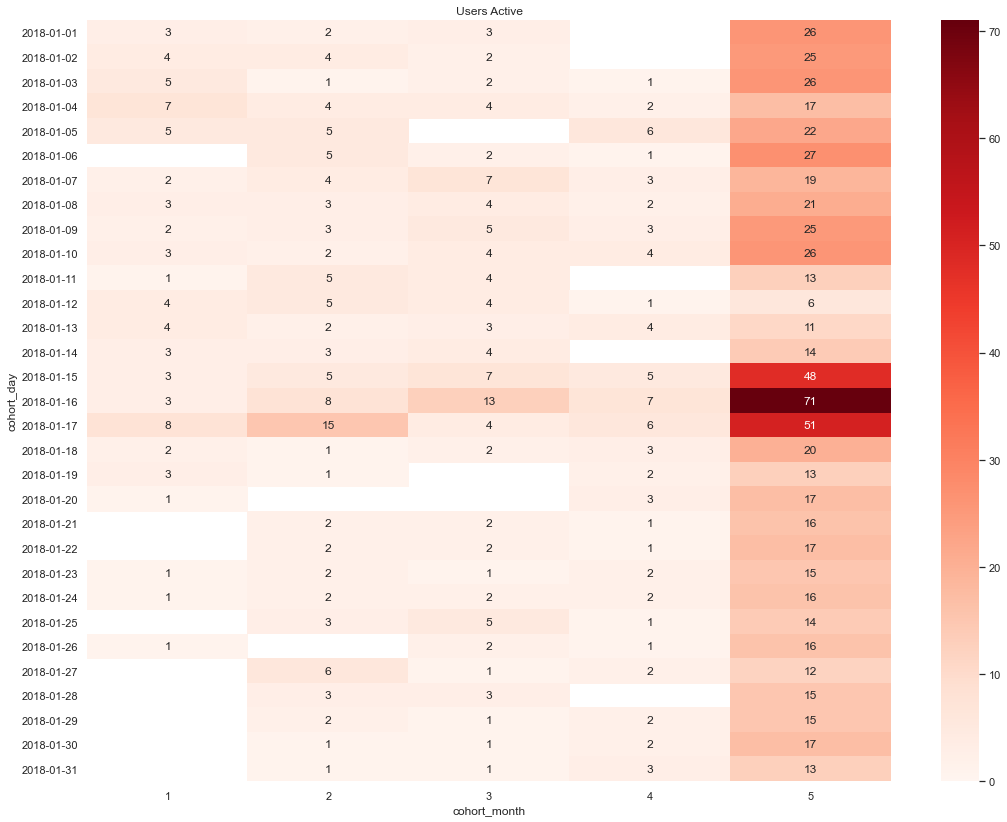

In [74]:
cohort_counts.index = cohort_counts.index.strftime('%Y-%m-%d')

plt.figure(figsize=(18,14))
plt.title('Users Active')
ax = sns.heatmap(data=cohort_counts, annot=True, vmin=0.0,cmap='Reds')
ax.set_yticklabels(cohort_counts.index)
fig=ax.get_figure()
plt.show()